In [1]:
from augur.utils import json_to_tree
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Seq import MutableSeq
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio import Phylo
from scipy import stats
import requests
import math
import json


Get global ncov tree and convert to Bio Phylo format

In [39]:
tree_url = 'https://nextstrain-blab.s3.amazonaws.com/ncov_adaptive-evolution_2021-05-15.json'

tree_json = requests.get(tree_url).json()

#Put tree in Bio.Phylo format
tree = json_to_tree(tree_json)

Add information about synonymous mutations as an attribute of the tree

In [40]:
# make dictionary with gene name as key and reference sequence of that gene as value
reference_sequence_aa = {}
reference_sequence_nt = {}


# make dictionary giving gene by genomic location 
reference_gene_locations = {}

# make dictionary saying what codon within the gene a certain genomic location falls within
# and whether the mutation is at pos 0, 1 or 2 within codon
reference_gene_codon = {}

for record in SeqIO.parse(open("reference_seq_edited.gb","r"), "genbank"):
    genome_seq = record.seq
    for feature in record.features:
        if feature.type == 'CDS':
            # allow RdRp to overwrite Orf1a and Orf1b, 
            # to take care of changed reading frame due to  ribosome slippage
            # S1 and S2 will also overwrite spike
            for pos in range(int(feature.location.start), int(feature.location.end)):
                reference_gene_locations[pos] = feature.qualifiers['gene'][0]
                codon_num = math.floor((pos-feature.location.start)/3)
                pos_in_codon = ((pos-feature.location.start)-codon_num*3)
                reference_gene_codon[pos] = (codon_num, pos_in_codon)
                
            gene_seq = feature.location.extract(record.seq)
            reference_sequence_nt[feature.qualifiers['gene'][0]] = gene_seq
            gene_seq_aa = gene_seq.translate()
            reference_sequence_aa[feature.qualifiers['gene'][0]] = gene_seq_aa

/Users/katekistler/anaconda3/envs/ncov/lib/python3.6/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


In [5]:
# dictionary of list of colors for emerging lineages, depending on total number of lineages
color_palettes = {8: ['#4068CF','#5098B9','#6CB28C','#94BD62','#BFBB47','#DFA53B','#E67131','#DB2823'], 
                  9: ['#3E5DD0','#4A8CC2','#60AA9E','#80B974','#A6BE55','#CBB742','#E29D39','#E56A2F','#DB2823'], 
                  10: ['#3F52CD','#4681CA','#57A1AD','#70B487','#90BC65','#B4BD4C','#D3B240','#E59638','#E4642E','#DB2823'], 
                  11: ['#3F47C9','#4274CE','#4F97BB','#64AC99','#7EB976','#9EBE5A','#BEBB48','#D9AE3E','#E69036','#E35F2D','#DB2823'], 
                  12: ['#403CC5','#4067CF','#4A8BC3','#5AA4A9','#6FB488','#8BBB69','#A9BD53','#C7B944','#DDA93C','#E68A35','#E35C2C','#DB2823'], 
                  13: ['#4433BE','#3E5ACF','#457FCB','#529AB6','#64AD98','#7BB77A','#96BD60','#B3BD4D','#CDB642','#DFA43B','#E68434','#E2582C','#DB2823'], 
                  14: ['#492AB5','#3F4CCB','#4271CE,''#4C8FC0','#5AA5A8','#6DB38A','#85BA6F','#A0BE59','#BBBC49','#D2B340','#E19F3A','#E68033','#E2562B','#DB2823'], 
                  15: ['#4D21AD','#403FC6','#3F63CF','#4783C8','#539BB5','#63AC9B','#77B67F','#8EBC66','#A8BD53','#C1BA47','#D6B03F','#E39C39','#E67C33','#E1532B','#DB2823'], 
                  16: ['#571EA2','#4334BF','#3F55CE','#4376CD','#4C91C0','#59A4A9','#6AB18F','#7FB975','#97BD5F','#AFBD4F','#C7B944','#D9AD3D','#E49838','#E67932','#E1512A','#DB2823'], 
                  17: ['#5E1D9D','#462EB9','#3F4CCB','#416CCE','#4887C6','#539CB3','#62AB9C','#74B582','#89BB6B','#A0BE59','#B7BD4B','#CCB742','#DDAA3C','#E69537','#E67631','#E14F2A','#DB2823']}
                      

In [6]:
#Function to find path from root to clade
def get_parent(tree, child_clade):
    node_path = tree.get_path(child_clade)
    return node_path

In [7]:
def nuc_changes_from_reference(muts_on_path):
    """
    From all the of the nucleotide changes that have occurred on the path from root to branch, 
    find the most recent nuc mutation at each site (giving the genotype at the branch)
    """
    
    final_muts_from_ref = {}

    # overwrites genotypes at pos in historical order
    for x in muts_on_path:
        x_pos = int(x[1:-1])
        final_muts_from_ref[x_pos] = x[-1]
        

    return final_muts_from_ref

In [41]:
def determine_synonymous(nuc_muts_on_branch, parent_diffs_from_ref):
    
    parent_diffs_pos = [int(k) for k,v in parent_diffs_from_ref.items()]

    
    # make dictionary of synonymous (and noncoding) mutations to add to tree
    syn_muts = {}
    
    # don't care about deletions because they are obviously not synonymous
    for mut in nuc_muts_on_branch:
        if mut[-1]!= '-' and mut[0]!='-':
            mut_pos = int(mut[1:-1])
            # find what gene this mut happens in
            if (mut_pos-1) in reference_gene_locations.keys():
                mut_gene = reference_gene_locations[mut_pos-1]
                mut_codon_num = reference_gene_codon[mut_pos-1][0]
                mut_codon_pos = reference_gene_codon[mut_pos-1][1]
                
                # find the reference sequence of the codon this mutation occurs in
                codon_ref_aa = reference_sequence_aa[mut_gene][mut_codon_num]
                
                codon_ref_nt = reference_sequence_nt[mut_gene][(mut_codon_num*3):(mut_codon_num*3+3)]
                
                # check if a mutation occurred within the same codon in a parent
                # and if so, change the reference codon sequence accordingly, 
                # to tell whether the mutation at this branch is synonymous or not
                codon_genome_pos = list(range((mut_pos-1-mut_codon_pos),(mut_pos-1-mut_codon_pos+3)))
                
                parent_codon = codon_ref_nt
                for parent_diff in parent_diffs_pos:
                    parent_diff_zero_based = parent_diff-1
                    if parent_diff_zero_based in codon_genome_pos:
                        parent_diff_pos = codon_genome_pos.index(parent_diff_zero_based)
                        parent_codon = MutableSeq(str(codon_ref_nt))
                        parent_codon[parent_diff_pos] = parent_diffs_from_ref[parent_diff]
                        parent_codon = parent_codon.toseq()
                
                
                codon_mutated = MutableSeq(str(parent_codon))
                #if deletion (or seq error) has happened at neighboring nucleotide
                if '-' in codon_mutated:
                    pass
                else:
                    codon_mutated[mut_codon_pos] = mut[-1]
                    codon_mutated = codon_mutated.toseq()
                    codon_mutated_translation = codon_mutated.translate()

                    if str(codon_ref_aa) == str(codon_mutated_translation):
                        if mut_gene in syn_muts.keys():
                            syn_muts[mut_gene] += [mut]
                        else:
                            syn_muts[mut_gene] = [mut]
                        
                

            else:
                if 'noncoding' in syn_muts.keys():
                    syn_muts['noncoding'] += [mut]
                else:
                    syn_muts['noncoding'] = [mut]
                    
    return syn_muts

In [9]:
def add_syn_mut_attribute(tree):
    
    for node in tree.find_clades():

        node.node_attrs['syn_muts'] = {}

        # only care if this branch has some nucleotide mutations
        if hasattr(node, 'branch_attrs'):
            if 'nuc' in node.branch_attrs['mutations']:

                nuc_muts_on_branch = node.branch_attrs['mutations']['nuc']

                node_path = get_parent(tree, node)

                nucleotide_mut_path = []

                # find all nucleotide mutations that happened in parents, 
                # in case they affect codons mutated on this branch
                for parent in node_path[-1]:
                    if hasattr(parent, 'branch_attrs'):
                        if 'nuc' in parent.branch_attrs['mutations']:
                            nucleotide_mut_path+=parent.branch_attrs['mutations']['nuc']

                parent_diffs_from_ref = nuc_changes_from_reference(nucleotide_mut_path)

                syn_muts_dict = determine_synonymous(nuc_muts_on_branch, parent_diffs_from_ref)

                node.node_attrs['syn_muts'] = syn_muts_dict


In [42]:
add_syn_mut_attribute(tree)

S1 mutations (from root-to-clade) are already a feature of each node in the tree. Count RdRp mutations via tree traversal and add this count to each node

In [16]:
#Find the path from root to internal node and accumulate all mutations that have occurred along this path
#Keep track of these just for S1, S2, and RdRp 

def get_parent(tree, child_clade):
    node_path = tree.get_path(child_clade)
    return node_path


def consolidate_deletions(mutation_list):
    """
    For deletion mutations, consider adjacent sites as part of the same deletion
    """
    mutation_count = len([x for x in mutation_list if x[-1]!='-'])
    deletions_only = sorted([int(x[1:-1]) for x in mutation_list if x[-1]=='-'])

    # if there are deletions, count a run of consecutive sites as a single deletion/mutation
    if len(deletions_only) != 0:
        mutation_count+=1

        deletion_tracker = deletions_only[0]
        for deleted_pos in deletions_only[1:]:
            if deleted_pos == deletion_tracker+1:
                pass
            else:
                mutation_count+=1
            deletion_tracker = deleted_pos
    return mutation_count

def remove_reversions(mutation_list):
    """
    If site mutates and then reverts, do not count this in the mutation tally.
    If site mutates and then mutates again (but not a reversion), count only the second mutation
    """
    mutation_list_pos = [int(x[1:-1]) for x in mutation_list]
    sites_mutated_twice = set([x for x in mutation_list_pos if mutation_list_pos.count(x) > 1])
    # find if twice-mutated site was a reversion
    for site in sites_mutated_twice:
        muts_at_site = [mut for mut in mutation_list if int(mut[1:-1])==site]

        # if site reverts, remove all mutations at this site
        if muts_at_site[0][0] == muts_at_site[-1][-1]:
            for mut in range(len(muts_at_site)):
                mutation_list.remove(muts_at_site[mut])
        # if the site mutates multiple times, but doesn't revert, keep last mutation
        else:
            for mut in range(len(muts_at_site)-1):
                mutation_list.remove(muts_at_site[mut])
    return mutation_list
    
    

In [52]:
# count mutation accumulation from root to each node
for node in tree.find_clades():
    
    # Find all parents of the node
    parents = get_parent(tree, node)

    # Keep track of all mutations in parents. 
    # Because numbering is relative to gene start, need to keep track of 
    # amino acid mutations by gene so that reversions can be determined
    parents_ORF1a_muts = []
    parents_ORF1b_muts = []
    parents_S_muts = []
    parents_ORF3_muts = []
    parents_E_muts = []
    parents_M_muts = []
    parents_N_muts = []
    parents_ORF6_muts = []
    parents_ORF7a_muts = []
    parents_ORF7b_muts = []
    parents_ORF8_muts = []
    parents_ORF9b_muts = []

    # synonymous mutation numbering is relative to start of genome, 
    # so can keep track of all at once
    parents_syn_muts = []


    for parent in parents:
        if hasattr(parent, "branch_attrs") and "mutations" in parent.branch_attrs:
            if "ORF1a" in parent.branch_attrs["mutations"]:
                parents_ORF1a_muts+=parent.branch_attrs["mutations"]["ORF1a"]
            if "ORF1b" in parent.branch_attrs["mutations"]:
                parents_ORF1b_muts+=parent.branch_attrs["mutations"]["ORF1b"]
            if "S" in parent.branch_attrs["mutations"]:
                parents_S_muts+=parent.branch_attrs["mutations"]["S"]
            if "ORF3" in parent.branch_attrs["mutations"]:
                parents_ORF3_muts+=parent.branch_attrs["mutations"]["ORF3"]
            if "E" in parent.branch_attrs["mutations"]:
                parents_E_muts+=parent.branch_attrs["mutations"]["E"]
            if "M" in parent.branch_attrs["mutations"]:
                parents_M_muts+=parent.branch_attrs["mutations"]["M"]
            if "N" in parent.branch_attrs["mutations"]:
                parents_ORF3_muts+=parent.branch_attrs["mutations"]["N"]
            if "ORF6" in parent.branch_attrs["mutations"]:
                parents_ORF6_muts+=parent.branch_attrs["mutations"]["ORF6"]
            if "ORF7a" in parent.branch_attrs["mutations"]:
                parents_ORF7a_muts+=parent.branch_attrs["mutations"]["ORF7a"]
            if "ORF7b" in parent.branch_attrs["mutations"]:
                parents_ORF7b_muts+=parent.branch_attrs["mutations"]["ORF7b"]
            if "ORF8" in parent.branch_attrs["mutations"]:
                parents_ORF8_muts+=parent.branch_attrs["mutations"]["ORF8"]
            if "ORF9b" in parent.branch_attrs["mutations"]:
                parents_ORF9b_muts+=parent.branch_attrs["mutations"]["ORF9b"]
        if hasattr(parent, 'node_attrs') and 'syn_muts' in parent.node_attrs:
            for g in parent.node_attrs['syn_muts'].keys():
                # only consider synonymous mutations within coding regions
#                 if g!= 'noncoding':
                parents_syn_muts += parent.node_attrs['syn_muts'][g]
            

    # remove reversion mutations from each list
    parents_ORF1a_muts = remove_reversions(parents_ORF1a_muts)
    parents_ORF1b_muts = remove_reversions(parents_ORF1b_muts)
    parents_S_muts = remove_reversions(parents_S_muts)
    parents_ORF3_muts = remove_reversions(parents_ORF3_muts)
    parents_E_muts = remove_reversions(parents_E_muts)
    parents_M_muts = remove_reversions(parents_M_muts)
    parents_N_muts = remove_reversions(parents_N_muts)
    parents_ORF6_muts = remove_reversions(parents_ORF6_muts)
    parents_ORF7a_muts = remove_reversions(parents_ORF7a_muts)
    parents_ORF7b_muts = remove_reversions(parents_ORF7b_muts)
    parents_ORF8_muts = remove_reversions(parents_ORF8_muts)
    parents_ORF9b_muts = remove_reversions(parents_ORF9b_muts)
    parents_syn_muts = remove_reversions(parents_syn_muts)




    # count deletion of adjacent nucleotides as one mutation event
    ORF1a_mutation_count = consolidate_deletions(parents_ORF1a_muts)
    ORF1b_mutation_count = consolidate_deletions(parents_ORF1b_muts)
    S_mutation_count = consolidate_deletions(parents_S_muts)
    ORF3_mutation_count = consolidate_deletions(parents_ORF3_muts)
    E_mutation_count = consolidate_deletions(parents_E_muts)
    M_mutation_count = consolidate_deletions(parents_M_muts)
    N_mutation_count = consolidate_deletions(parents_N_muts)
    ORF6_mutation_count = consolidate_deletions(parents_ORF6_muts)
    ORF7a_mutation_count = consolidate_deletions(parents_ORF7a_muts)
    ORF7b_mutation_count = consolidate_deletions(parents_ORF7b_muts)
    ORF8_mutation_count = consolidate_deletions(parents_ORF8_muts)
    ORF9b_mutation_count = consolidate_deletions(parents_ORF9b_muts)
    syn_mutation_count = consolidate_deletions(parents_syn_muts)


    node.node_attrs["syn_accumulation"] = syn_mutation_count
    
    node.node_attrs["ORF1a_mut_accumulation"] = ORF1a_mutation_count
    node.node_attrs["ORF1b_mut_accumulation"] = ORF1b_mutation_count
    node.node_attrs["S_mut_accumulation"] = S_mutation_count
    node.node_attrs["ORF3_mut_accumulation"] = ORF3_mutation_count
    node.node_attrs["E_mut_accumulation"] = E_mutation_count
    node.node_attrs["M_mut_accumulation"] = M_mutation_count
    node.node_attrs["N_mut_accumulation"] = N_mutation_count
    node.node_attrs["ORF6_mut_accumulation"] = ORF6_mutation_count
    node.node_attrs["ORF7a_mut_accumulation"] = ORF7a_mutation_count
    node.node_attrs["ORF7b_mut_accumulation"] = ORF7b_mutation_count
    node.node_attrs["ORF8_mut_accumulation"] = ORF8_mutation_count
    node.node_attrs["ORF9b_mut_accumulation"] = ORF9b_mutation_count
    node.node_attrs['nonsyn_accumulation'] = (ORF1a_mutation_count+ORF1b_mutation_count+
                                              S_mutation_count+ORF3_mutation_count+
                                              E_mutation_count+M_mutation_count+
                                              N_mutation_count+ORF6_mutation_count+
                                              ORF7a_mutation_count+ORF7b_mutation_count+
                                              ORF8_mutation_count+ORF9b_mutation_count)

Make dataframe to plot 1) accumulation of S1 vs RdRp mutations over time, 2) S1 vs RdRp mutation count versus logistic growth

In [45]:
def convert_linege_names(old_name):
    
    old_to_new = {'unassigned': 'basal'}
    if old_name in old_to_new.keys():
        new_name = old_to_new[old_name]
    else:
        new_name = old_name
    
    return new_name

In [55]:
# make dataframe of relevant information
muts_information = []

for node in tree.find_clades(terminal=False):

    
    logistic_growth = None
    if "logistic_growth" in node.node_attrs:
        logistic_growth = node.node_attrs["logistic_growth"]["value"]
    
    if hasattr(node, "node_attrs"):
        date = node.node_attrs["num_date"]["value"]
        clade_membership = 'other'
        if 'clade_membership' in node.node_attrs:
            clade_membership = node.node_attrs['clade_membership']['value']
            

        if 'emerging_lineage' in node.node_attrs:
            emerging_lineage = node.node_attrs['emerging_lineage']['value']
            emerging_lineage = convert_linege_names(emerging_lineage)
            
            
        muts_information.append({'clade': node.name, 'date': date,
                                 'clade_membership': clade_membership,
                                 'emerging_lineage': emerging_lineage,
                                 'mut_location': "synonymous", 
                                 'num_muts': node.node_attrs["syn_accumulation"],
                                 'logistic_growth': logistic_growth})
        muts_information.append({'clade': node.name, 'date': date,
                                 'clade_membership': clade_membership,
                                 'emerging_lineage': emerging_lineage,
                                 'mut_location': "nonsynonymous", 
                                 'num_muts': node.node_attrs["nonsyn_accumulation"],
                                 'logistic_growth': logistic_growth})

muts_information_df = pd.DataFrame(muts_information)
    


In [50]:
def get_linear_reg_stats(mut_location, x_axis):
    
    df_subset = muts_information_df.copy()
    df_subset = df_subset[df_subset['mut_location']==mut_location]
    
    if x_axis == 'logistic_growth':
        df_subset = df_subset.dropna()
    
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_subset[x_axis], df_subset['num_muts'])
    slope = round(slope, 4)
    r_value = round(r_value, 2)
    
    return slope, r_value

In [67]:
# plot number of s1 and rdrp mutations versus logistic growth rate
# color by clade membership


def plot_muts_vs_logistic_growth_genomewide(filename=None):
    
    all_emerging_lineages = sorted(list(set(muts_information_df['emerging_lineage'])))
    all_emerging_lineages.remove('basal')
    colors_to_use = color_palettes[len(all_emerging_lineages)]
    
    cmap = dict(zip(all_emerging_lineages, colors_to_use))
    cmap['basal'] = "#ABABAB"

    


    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(14,10), sharey=True)
    plt.tight_layout()



    # plot genome-wide nonsynonymous mutations versus date, color by clade membership
    ax1 = sns.scatterplot(x="date", y="num_muts", hue= 'emerging_lineage',
                          hue_order= list(cmap.keys()), palette=cmap,
                          data = muts_information_df[muts_information_df['mut_location']=='nonsynonymous'], 
                          ax=ax1, legend=False)
    # add linear regression line
    sns.regplot(x="date", y="num_muts", scatter=False, ax=ax1, 
                data = muts_information_df[muts_information_df['mut_location']=='nonsynonymous'], 
                line_kws={"color":'black'}, ci=95)
    ax1.set_ylabel('Mutations', fontsize = 14)
    ax1.set_xlabel('Date', fontsize = 14)
    ax1.set_title('Nonsynonymous', fontsize = 16, fontweight='bold')
    
    slope1, r_value1 = get_linear_reg_stats('nonsynonymous', 'date')
    ax1.annotate(f'{format(slope1, "10.2E")} muts per year \n $R^2$: {r_value1}', xy=(2020.0,45), size=12, va='top', ha='left')
    

    # plot genome-wide synonymous mutations versus date, color by clade membership
    ax2 = sns.scatterplot(x="date", y="num_muts", hue= 'emerging_lineage',
                          hue_order= list(cmap.keys()), palette=cmap,
                          data = muts_information_df[muts_information_df['mut_location']=='synonymous'], 
                          ax=ax2, legend=False)
    # add linear regression line
    sns.regplot(x="date", y="num_muts", scatter=False, ax=ax2, 
                data = muts_information_df[muts_information_df['mut_location']=='synonymous'], 
                line_kws={"color":'black'}, ci=95)
    ax2.set_xlabel('Date', fontsize = 14)
    ax2.set_title('Synonymous', fontsize = 16, fontweight='bold')
    
    slope2, r_value2 = get_linear_reg_stats('synonymous', 'date')
    ax2.annotate(f'{format(slope2, "10.2E")} muts per year \n $R^2$: {r_value2}', xy=(2020.0,45), size=12, va='top', ha='left')
    


    # plot genome-wide nonsynonymous mutations versus growth rate, color by clade membership
    ax3 = sns.scatterplot(x="logistic_growth", y="num_muts", hue= 'emerging_lineage',
                          hue_order= list(cmap.keys()), palette=cmap,
                          data = muts_information_df[muts_information_df['mut_location']=='nonsynonymous'], 
                          ax=ax3, legend=False)
    # add linear regression line
    sns.regplot(x="logistic_growth", y="num_muts", scatter=False, ax=ax3, 
                data = muts_information_df[muts_information_df['mut_location']=='nonsynonymous'], 
                line_kws={"color":'black'}, ci=95)
    ax3.set_ylabel('Mutations', fontsize = 14)
    ax3.set_xlabel('Logistic Growth Rate', fontsize = 14)
    ax3.set_title('Nonsynonymous', fontsize = 16, fontweight='bold')
    
    slope3, r_value3 = get_linear_reg_stats('nonsynonymous', 'logistic_growth')
    ax3.annotate(f'$R^2$: {r_value3}', xy=(-20,45), size=12, va='top', ha='left')
    


    # plot genome-wide nonsynonymous mutations versus growth rate, color by clade membership
    ax4 = sns.scatterplot(x="logistic_growth", y="num_muts", hue = 'emerging_lineage', 
                          hue_order= list(cmap.keys()), palette=cmap,
                          data = muts_information_df[muts_information_df['mut_location']=='synonymous'], 
                          ax=ax4, legend=False)
    # add linear regression line
    sns.regplot(x="logistic_growth", y="num_muts", scatter=False, ax=ax4, 
                data = muts_information_df[muts_information_df['mut_location']=='synonymous'], 
                line_kws={"color":'black'}, ci=95)
    ax4.set_xlabel('Logistic Growth Rate', fontsize = 14)
    ax4.set_title('Synonymous', fontsize = 16, fontweight='bold')
    
    slope4, r_value4 = get_linear_reg_stats('synonymous', 'logistic_growth')
    ax4.annotate(f'$R^2$: {r_value4}', xy=(-20,45), size=12, va='top', ha='left')

    
    sns.despine(left=False, bottom=False)
    plt.subplots_adjust(hspace=0.3, wspace=0.1)
    
    for ax in [ax1, ax2]:
        ax.set_ylim(-0.0025, 50)
        ax.set_xlim(2019.9, 2021.38)
        plt.setp(ax.get_xticklabels(), fontsize=10)
        plt.setp(ax.get_yticklabels(), fontsize=12)
        
    for ax in [ax3, ax4]:
        ax.set_ylim(-0.0025, 50)
        ax.set_xlim(-23, 15)
        plt.setp(ax.get_xticklabels(), fontsize=12)
        plt.setp(ax.get_yticklabels(), fontsize=12)
    
    plt.figtext(-0.03, 0.98, 'A', fontsize=24, fontweight='bold')
    plt.figtext(-0.03, 0.48, 'B', fontsize=24, fontweight='bold')
    

    if filename: 
        fig.savefig(filename, dpi=300, bbox_inches='tight')

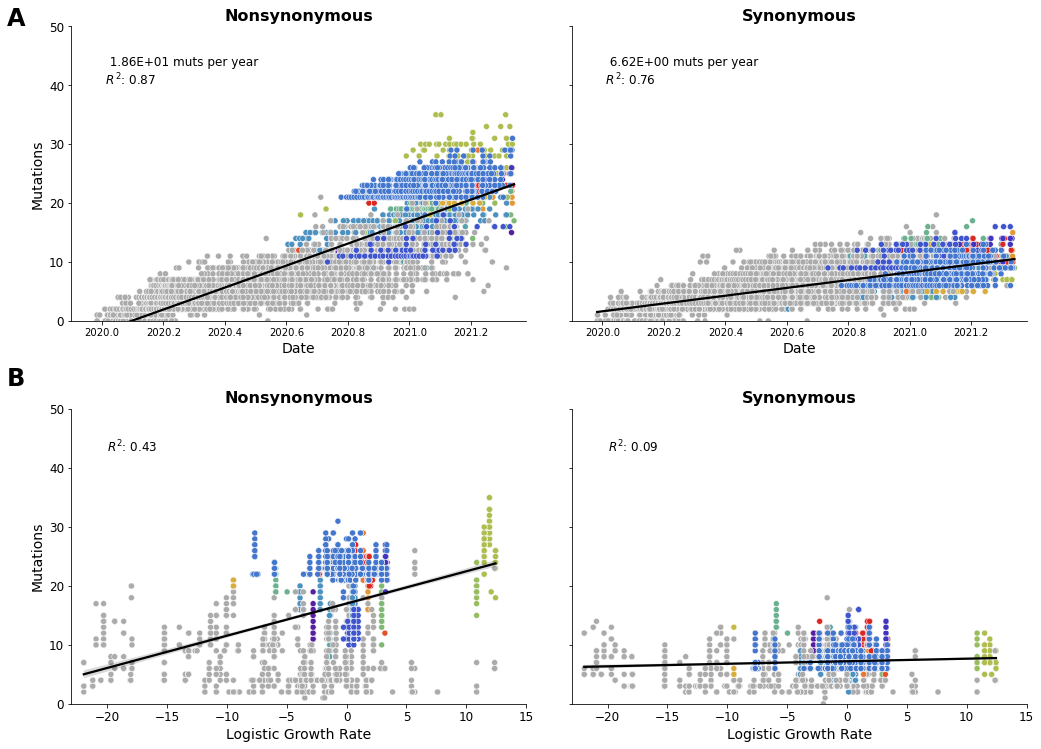

In [68]:
plot_muts_vs_logistic_growth_genomewide()